# Bayesian Analysis for Decision Focused Evaluations
When analyzing data from our evaluations, we typically use a "frequentist" or "null hypothesis testing" approach.  If you haven't heard the term "frequentist" that's probably because this approach is so dominant in academia that most people simply think of it as *the* approach to doing statistics. 

There is an alternative approach to doing statistics though: the Bayesian approach.  In this blog post I hope to show that Bayesian analysis may be particularly useful for the work we do by going through the use of a simplified example application inspired by a recent proejct.  

I'm going to use a couple of programming languages which you might not be familiar to work through the example: Python and Stan.  If you don't know these languages, don't worry. Most of the key points will be clear even if you have not been exposed to these languages.  (If not, please let me know and I will try to clarify further by adding comments to the code.)

## Why Bayes?
Bayes vs frequentist is a hotly contested debate so take this with a grain of salt but here's my take. Bayesian analysis is more useful when the purpose of the analysis is to inform a specific decision by a specific actor. This is because Bayesian analysis let's you take the actor's prior beliefs into account and the output from analysis tells the actor exactly what decision to make (i.e. -- you can just tell the client "you should do X" rather than trying to explain what a p-value is). You may be asking "if this is true, why is frequentist analysis the dominant paradigm?" This is because frequentist analysis is more useful when there are a lot of people performing a lot of evaluations and the purpose of each analysis is to convince the larger community that the results are not due to chance.  Thus, while frequentist analysis is a reasonable approach in academia and for knowledge focused evaluations I think that Bayesian analysis is more useful for decision focused evaluations. 

Here's XKCD on the difference between the two approaches:  

![title](http://imgs.xkcd.com/comics/frequentists_vs_bayesians.png)

## A Motivating Example
I am currently involved in a five arm RCT for a client here in India.  The main purpose of this evaluation is help the client, an NGO, determine which of the five interventions they should drop and which they should continue to implement.  In order to make this decision, the client wants to know the probability of each treatment arm having the largest effect.  Unfortunately, it's hard to give a straight answer to that question using a frequentist approach.  We can answer questions like "what is the probability that we would see data this extreme if treatment arm 1 actually has no effect" or "what is the probability that we would see data as extreme as this if treatment arm 1 and treatment arm 2 actually have the same effect" but it's very difficult to estimate the probability of each treatment arm having the largest effect.

## Step 1: Generate Some Data
In future blog posts, I hope to use real client data to demonstrate this approach but for now let's start with some fake data.  To generate some fake data, I assume the true data generating process for the RCT is...

$$ y_i \sim N(\tau_{j[i]},\sigma_y^2) $$

Where i indexes households, j indexes treatment arms, and j = 0 indicates the control group. I pick arbitrary values for the parameters.  The code for generating this data in Python is included below but again, don't worry if the details don't make sense. 

*Note: If you don't want to go through the code, you can skip down until "Step 3"*

In [1]:
# import numpy -- this is a python "package" for linear algebra
import numpy as np

# Initialize random number generator
np.random.seed(123)

# Set values for the various parameters in the data generating equation. 
sigma = 1
tau = [.1,.5,1.6,2,0,-0.7]

# Size of each treatment arm
size_arms = np.array([20, 10, 10, 20, 20, 15])

# generate a vector indicating the arm for each observation. 
# I add 1 because array indices start with 0 in python but 1 in Stan
arm = np.repeat(np.arange(6),size_arms) + 1

# Simulate outcome variable
Y = np.repeat(tau, size_arms)+ np.random.randn(sum(size_arms))*sigma

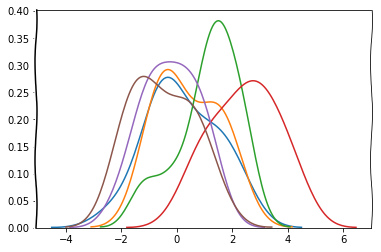

In [2]:
# Graph this data to make sure it looks reasonable
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# this next line gives the graph the XCD feel
plt.xkcd()
start = 0
for size in size_arms:
    end = start + size
    sns.distplot(Y[start:end], hist = False)
    start = end

This appears to be about what we would expect given our effect sizes.

## Step 2: Fit the Data Using Stan
Great.  We've generated some data.  Now we use Stan, a special purpose probabilistic programming language, to fit that data using a Bayesian hierarchical model.  I'm going to use a model very similar to the data generating model to fit the data.  This is cheating a little bit, but it makes things a little simpler.

In [3]:
# import the pystan package.  this package allows python to call the Stan language
import pystan
# The next few lines define the model in Stan.  The entire Stan model is saved as the python variable
# stan_code which I use later to fit the model. 
stan_code = '''
data {
    int<lower=0> N;  // number of observations
    int<lower=1> J;  // number of treatment arms
    real y[N];  // outcome data
    int<lower=1,upper=J> jj[N];  // variable indicating treatment arm for each observation
}
parameters {
    real tau[J];
}
model {
    tau ~ normal(0,10);  // Assign tau a multivariate normal prior with no correlations.  
    // the above two statements shows how Stan automatically "vectorizes" operations where appropriate
    for (n in 1:N)
        y[n] ~ normal(tau[jj[n]], 5);
}
'''
stan_data = {'N': sum(size_arms),
        'J': len(size_arms),
        'y': Y,
        'jj': arm }


In [4]:
fit = pystan.stan(model_code=stan_code, data=stan_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a075e8704c168e2aa41141a919d3562f NOW.


CompileError: command 'gcc' failed with exit status 1

## Step 3: Use the Posterior to Answer the Client's Question
After fitting our model, the final output is a set of draws from the "posterior" distribution of our parameters. That is, we get a big list each element of which is a draw from our estimated distribution of the parameters.  This is a much richer output than for Stata's "regress" command which only gives point estimates and an estimated covariance matrix for our parameters. 

Having access to the complete parameter distribution allows us to perform rich anlaysis on the parameters. For example, for each draw from the posterior distribution, we can look at which of the arms has the largest effect (i.e. which element of the vector $\tau_j$ is the largest).  This gives us the probability that each of the treatment arms is the "best" -- what the client originally wanted.  

In [12]:
# pandas is another python package that is really useful for manipulating datasets
import pandas as pd
# get the full set of draws from the posterior for tau and store this in tau_sim
tau_sim = fit.extract()['tau']
# for each of the draws from the posterior, identify which element of tau is the largest
results =  pd.DataFrame({'max':np.argmax(tau_sim, 1)})
# for each element of tau, total up the number of times when that element is the largest
results['max'].value_counts()/2000

3    0.6285
2    0.1850
1    0.1110
0    0.0325
5    0.0255
4    0.0175
Name: max, dtype: float64

Voila!  We see that our model estimates treatment arm 3 (the actual best arm) as being the best with 62.6% probability.  Of course, we cheated a little by using a data generating model that was the same as our estimation model.

The goal of this post was to provide an example in which Bayesian analysis can answer a question that the client might have that frequentist analysis can't.  In future posts, I hope to show some other ways that Bayesian analysis might be useful for our work.  